# `dPdI.ipynb`

Calculate dPdI from dIdV output, use to calculate NEP from PSD

In [1065]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st
import scipy.signal as sg


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [1066]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'D:', # on the cryolab2 computer
    'C:/Users/MINER/Documents', # on Oxford computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13 Cryolab', *folder_base_candidates)
print(folder_base)

C:/Users/MINER/Documents


In [1067]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

required data inputs

In [1068]:
# read in results from IbIs analysis
#with open('./ibis_data/local/20241108-0001_results.dat', 'rb') as f:
#    ibis, ivfits, tr_fits = pickle.load(f)

if 0:
    with open('C:/Users/MINER/Documents/B13 Cryolab/Run3/dIdV Data/20250419_results.dat', 'rb') as f:
        didvfit = pickle.load(f)

    channels = 'ACD'

elif 1:
    with open('C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_results.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'ABCD'
else:
    with open('C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_results_doubled.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'ABCD'


with open('C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_numerical_dpdi.dat', 'rb') as f:

    dpdi_num = pickle.load(f)

# needed for power spectrum of pulse
psd_path = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/'

template_path = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/' # saturday
template_path2 = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/' # saturday


# needed for phonon collection efficiency calc

sumbcd = 1.54636e-8 # peak position in sum 


"""
run 3 numbers

saturday data, cutting D
A - 8.28e-7
C - 1.84e-6
D - 2.78e-6

saturday data, individual channel cuts
A - 1.433e-6
C - 2.816e-6
D - 2.827e-6

no PT (no cuts)
A - 4.5e-7
C - 7e-7
D - 9e-7

tuesday data
A - 3.13e-6 (cutting A)?
C - 2.41e-6 (cutting C)
D - 2.78e-6 (cutting D)

"""


# position of peaks in calibration (OF height where peak occurs)
peak_positions = {
    'A': 9.98e-7,
    'B': 4.485e-7,
    'C': 1.918e-6, #6.47901e-8,
    'D': 3.451e-6, #5.42406e-8,
}

peak_energy = 59.54 # energy of peak (keV)

In [1069]:
for c in 'ABCD':
    print(c, didvfit[c][3]['params']['dt'])

A 1.3988241014678412e-06
B 1.531775472265221e-06
C 1.451346918055778e-06
D 1.4261337332817387e-06


In [1070]:
didvfit["A"][3]

{'lgcfix': None,
 'params_array': array([9.73009468e-05, 1.98410725e-01, 6.28118373e-01, 1.05804465e-06,
        6.33795077e-03, 2.74789088e-05, 1.39882410e-06]),
 'params': {'A': np.float64(9.730094682429542e-05),
  'B': np.float64(0.1984107246664275),
  'C': np.float64(0.628118372549983),
  'tau1': np.float64(1.0580446499238353e-06),
  'tau2': np.float64(0.006337950772040725),
  'tau3': np.float64(2.7478908810779833e-05),
  'dt': np.float64(1.3988241014678412e-06)},
 'cov': array([[ 2.51652225e-14,  1.59301034e-12, -9.15180251e-11,
          9.21608003e-17, -1.51115167e-12, -1.83076016e-15,
         -1.90556817e-17],
        [ 1.59300926e-12,  3.93741870e-09,  3.56964970e-09,
          7.73801521e-14, -2.63244416e-13,  1.28547147e-12,
         -2.17067618e-15],
        [-9.15183319e-11,  3.56965600e-09,  3.69595715e-07,
         -7.00925669e-14,  5.95476999e-09,  1.03453676e-11,
          3.14485446e-14],
        [ 9.21608941e-17,  7.73801498e-14, -7.00926842e-14,
          2.9358185

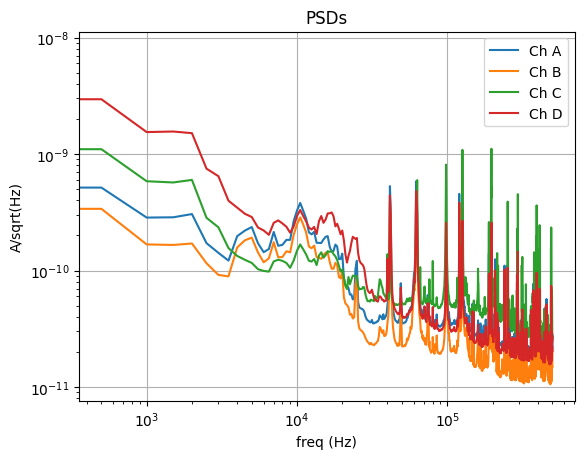

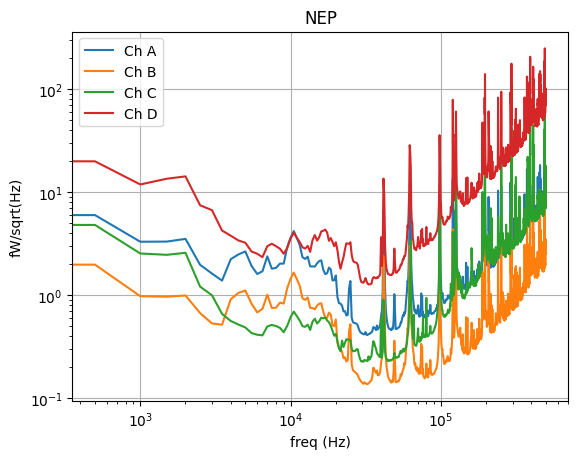

In [1071]:
# calculate NEP from PSD data and write to txt files

def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = np.loadtxt(filename)
    fs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return fs, psd

fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')


dpdi = {}

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(fs, didvfit[chan][3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(fs, psd, label = f'Ch {chan}')
    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')


ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



Text(0, 0.5, 'dPdI')

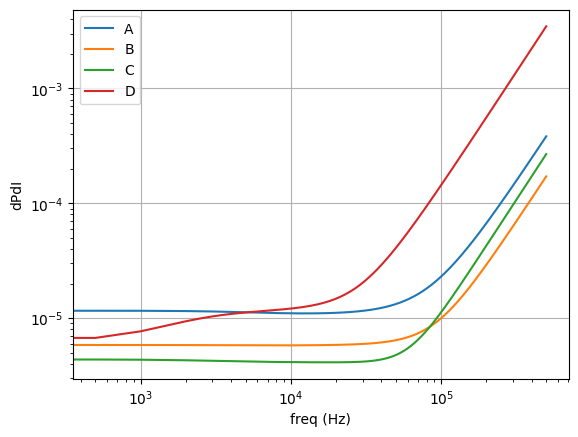

In [1072]:
plt.figure()
plt.loglog()
plt.grid()
for chan in channels:
    plt.plot(fs, abs(dpdi[chan]), label = chan)
    #plt.plot(fs, abs(dpdi_num[chan][:len(fs)]), label = chan)

plt.legend()
plt.xlabel('freq (Hz)')
plt.ylabel('dPdI')

In [1073]:
dpdi_num['A'][:40], dpdi_num['A'][:40:10]

(array([-1.29346949e-05+3.54863130e-08j, -1.17277829e-05+2.98819931e-07j,
        -1.38555898e-07+3.39616999e-08j, -1.16098022e-05+3.21368829e-07j,
        -2.06335129e-06+4.27175515e-07j, -1.14478909e-05+3.51458536e-07j,
        -3.01078022e-06+5.67984992e-07j, -1.13199396e-05+3.74472824e-07j,
        -2.45394399e-06+4.89069013e-07j, -1.11885741e-05+3.97430675e-07j,
        -3.51753537e-06+6.28969058e-07j, -1.10976139e-05+4.12878116e-07j,
        -1.92188155e-06+4.02542642e-07j, -1.10185948e-05+4.26008347e-07j,
        -1.38949858e-06+3.05355921e-07j, -1.09368041e-05+4.39342852e-07j,
        -9.94286726e-07+2.26137919e-07j, -1.08413650e-05+4.54596391e-07j,
        -2.75740017e-06+5.32361921e-07j, -1.07627172e-05+4.66864065e-07j,
        -3.06057524e-06+5.72877528e-07j, -1.06958315e-05+4.77076230e-07j,
        -2.91036926e-06+5.52915664e-07j, -1.06475167e-05+4.84289236e-07j,
        -8.14602960e-07+1.87860337e-07j, -1.06096584e-05+4.89833458e-07j,
        -3.28033962e-06+5.99530617e-07

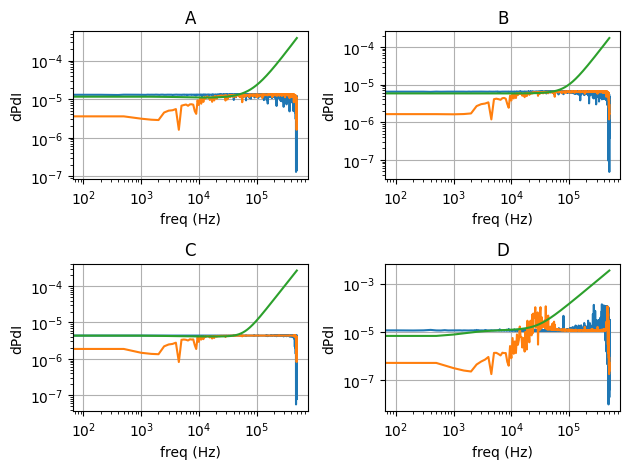

In [1074]:
fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    ax.loglog()
    ax.grid()
for chan, ax in zip(channels, axs.flatten()):
    ax.plot(dpdi_num['freq'], abs(dpdi_num[chan]), label = chan)
    ax.plot(fs, abs(dpdi_num[chan][::10]))
    ax.plot(fs, abs(dpdi[chan]))
    ax.set_title(chan)

    #plt.legend()
    ax.set_xlabel('freq (Hz)')
    ax.set_ylabel('dPdI')

fig.tight_layout()

In [1075]:
fs.shape, dpdi_num['freq'].shape

((1000,), (10000,))

In [1091]:
if 1:
    for chan in channels:
        dpdi[chan] = dpdi_num[chan][::10]

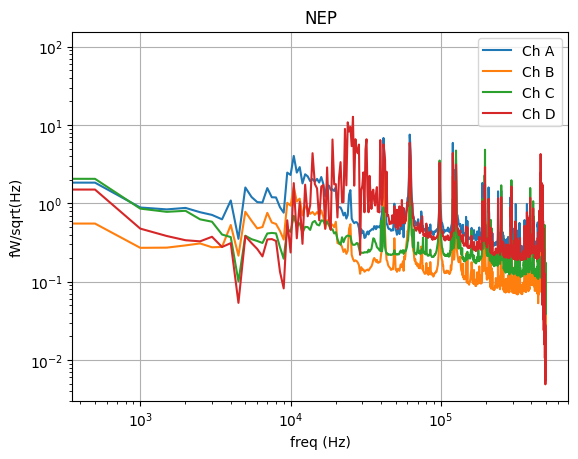

In [1092]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

#ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [1093]:
dpdi['A'].shape, psd.shape

((1000,), (1000,))

In [1094]:
# np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

In [1095]:
# get pulse templates

templates_unnorm = {}
templates = {}
templates2 = {}

for c in channels:

    templates_unnorm[c] = np.loadtxt(template_path + f'Templates 2/Ch {c} Template.txt')

    templates2[c] = templates_unnorm[c]/templates_unnorm[c].max()

    templates_unnorm2 = np.loadtxt(template_path2 + f'Ch {c} Average Templates.txt')

    templates[c] = templates_unnorm2/templates_unnorm2.max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates['A'].size, 1e-3) # templates = 2 ms traces

sampling_freq = templates['A'].size/2e-3 # Hz

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

In [1096]:
if 0:
    # butterworth filter at 50 kHz
    filter_order = 10
    filter_freq = 5e4 # Hz
    butt = sg.butter(N = filter_order, Wn = filter_freq, btype = 'lowpass', output = 'sos', fs = sampling_freq)

    for c in channels:
        templates[c] = sg.sosfilt(butt, templates[c])
        templates[c] /= templates[c].max()

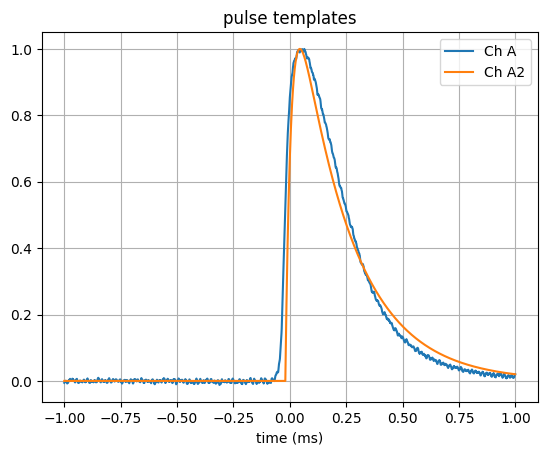

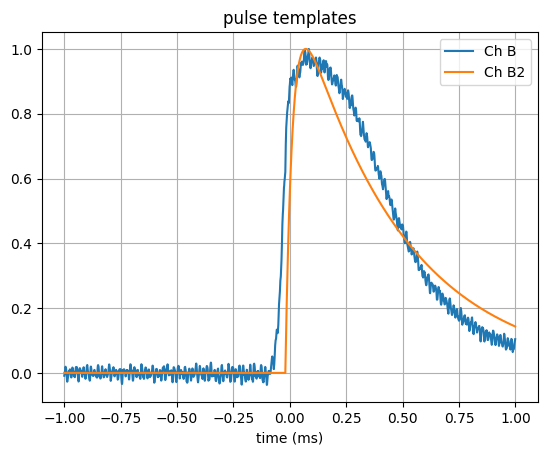

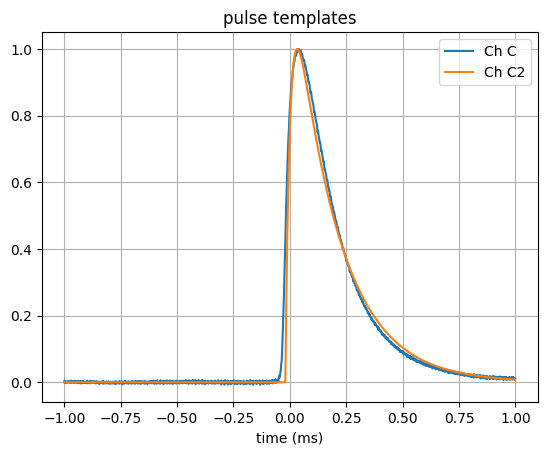

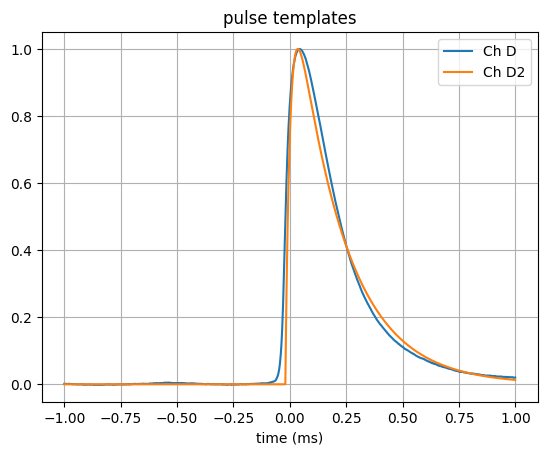

In [1097]:


for c in channels:
    plt.figure()
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

    #plt.axis((-0.2, 0.2, 0.5,1.1))
    plt.title('pulse templates')
    plt.grid()
    plt.legend()
    plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

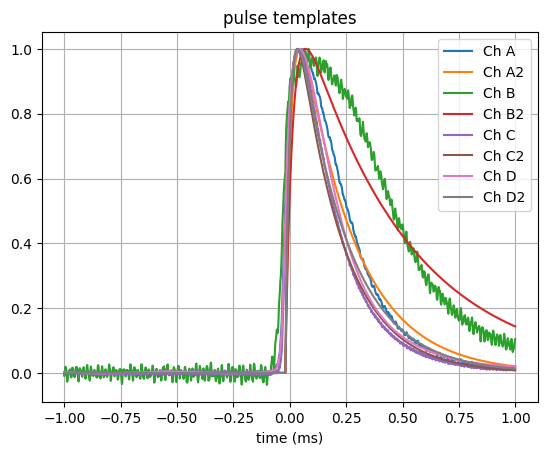

In [1098]:
plt.figure()

for c in channels:
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

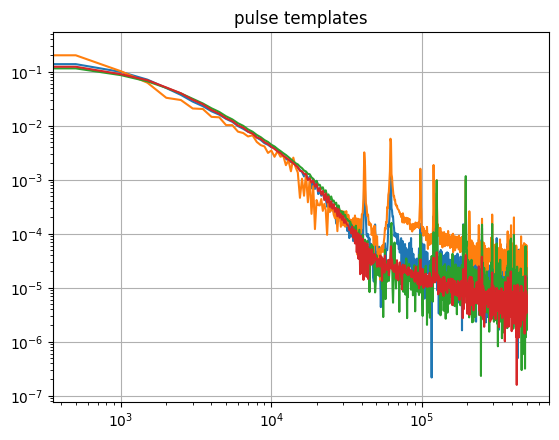

In [1099]:
plt.figure()

for c in channels:
    plt.plot(fs, abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [1100]:
# convert templates to frequency domain and convert to power
pulse_power = {}

template_energy = {} # energy (keV) of template

edge_cut = 5

for c in channels:

    temp_w = of.fft(templates[c]) # template current frequencies

    #dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))

    pow_w = temp_w*dpdi_unfolded # template power frequencies

    pulse_power[c] = of.ifft(pow_w) # template power

    template_energy[c] = np.trapz(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16 # energy of unit-height template in keV
    

Text(0.5, 0, 'time (ms)')

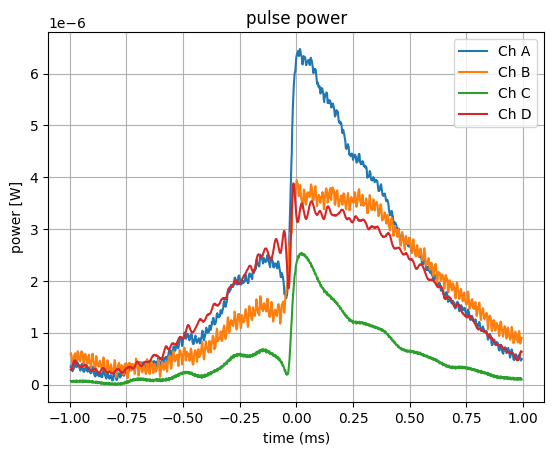

In [1101]:
plt.figure()

for c in channels:
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [1102]:
template_energy

{'A': np.float64(25829511.667593796),
 'B': np.float64(21085040.86312924),
 'C': np.float64(7202330.673050221),
 'D': np.float64(21473670.195187323)}

In [1103]:
resolutions = {}
resolutions2 = {}
resolutions3 = {}

print('energy resolutions (3 estimation methods)')

for c in channels:

    fs, psd = read_PSD(psd_path + f'PSD/Ch {c} PSD.txt', nsamples = 1000_000, trace_length = 1) # Hz, A/sqrt(Hz)

    nep = (abs(psd)*abs(dpdi[c]))**2 # W^2/Hz
    Jn = abs(psd)**2 # A^2/Hz

    resolutions[c] = of.resolution(templates[c]/templates[c].max(), np.hstack((Jn, Jn[::-1]))/2, 1.)*template_energy[c] # keV

    #resolutions2[c] = of.resolution(np.real(pulse_power[c])/np.real(pulse_power[c]).max(), np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c]/np.real(pulse_power[c]).max() # of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)
    resolutions2[c] = of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c] # keV

    resolutions3[c] = qp.utils.energy_resolution(np.hstack((psd, psd[::-1]))/2, templates[c], np.hstack((dpdi[c], dpdi[c][::-1]))/2, fs.max(), lgc_current_template = 1)

    print(f'{c}: {1e3*np.real(resolutions[c]):.5g} eV, {1e3*np.real(resolutions2[c]):.5g} eV, {1e3*np.real(resolutions3[c]):.5g} eV')

    if 0:#c == 'E':
        sn = of.fft(templates[c]/templates[c].max())
        J1 = np.hstack((Jn, Jn[::-1]))/2
        sn2 = of.fft(pulse_power[c]/pulse_power[c].max())
        J2 = np.hstack((nep, nep[::-1]))/2
        plt.figure(figsize = (4,3))
        plt.grid()
        plt.title(c)
        a = np.sqrt(abs(sn)**2/J1)/template_energy[c]
        b = np.sqrt(abs(sn2)**2/J2)*1.6e-16
        plt.plot(a)
        plt.plot(b)
        plt.loglog()
        ratio = a/b
        print(f'ratio: {np.real_if_close(ratio.mean()):.6g} +/- {np.real_if_close(ratio.std()):.6g}')

energy resolutions (3 estimation methods)
A: 15.507 eV, 15.507 eV, 2.076e+10 eV
B: 8.3243 eV, 8.3243 eV, 1.2932e+10 eV
C: 5.5834 eV, 5.5834 eV, 7.6859e+09 eV
D: 42.485 eV, 42.485 eV, 3.6601e+10 eV


In [1104]:
# calculate phonon collection efficiency

print('phonon collection efficiencies')
sum_eff = 0
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        sum_eff += template_energy[c]/unit_energy
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

print(f'total: {100*sum_eff:.5g}%')

phonon collection efficiencies
A : 43.295 %
B : 15.883 %
C : 23.201 %
D : 124.46 %
total: 206.84%


Text(0.5, 0, 'time (ms)')

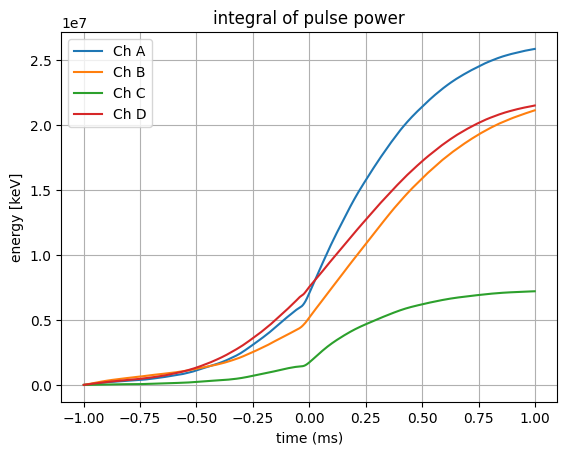

In [1105]:
# cumulative energy
plt.figure()

for c in channels:
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')